실습 목표

 * 영상 데이터를 불러오는 방법을 안다.
 * 딥러닝 모델의 층을 쌓는 방법을 안다.
 * 모델을 학습하는 방법과 학습한 모델을 평가하는 방법을 안다.
 * 이론으로 배운 개념이 어디에 적용되는지 확인한다.

목차

 * I. 입출력 데이터 처리
   1. 데이터 세트 불러오기
   2. 데이터 전처리
     1. 데이터 크기 조정하기
     2. 데이터 셔플
 * II. 커스텀 모델 학습 및 평가
   5. 모델 빌드 및 컴파일
   6. 모델 학습
   7. 모델 평가
 * III. CNN 모델 학습 및 평가
   5. 모델 빌드 및 컴파일
   6. 모델 학습
   7. 모델 평가

In [1]:
import os, random

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf

2025-09-01 04:17:38.458897: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-01 04:17:40.252849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-01 04:17:49.345365: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# 데이터 저장 경로
DATA_DIR = './chest_xray_dataset'

# 클래스 정보
labels = ['NORMAL', 'PNEUMONIA']

# I. 입출력 데이터 처리

## 1. 데이터 세트 불러오기

### 1) 데이터 하나만 읽어보기

python의 `opencv`라는 라이브러리를 활용하여 다양한 컴퓨터 비전 관련 처리를 수행할 수 있음

In [5]:
data_path = os.path.join(DATA_DIR, 'val', 'PNEUMONIA', 'person1951_bacteria_4882.jpeg')
data_path

'./chest_xray_dataset/val/PNEUMONIA/person1951_bacteria_4882.jpeg'

`cv2.imread()` 메서드를 사용하면 이미지 데이터(jpeg, png, tiff, ...)를 읽어올 수 있음.

In [6]:
img = cv2.imread(data_path)
img.shape, img.min(), img.max()

((656, 1016, 3), np.uint8(0), np.uint8(255))

영상 데이터는 (세로, 가로, 채널) 형태의 shape을 가지며, 이 데이터는 RGB 색공간을 가져 0에서 255 사이의 값을 가지는 것을 알 수 있음

그렇다면 이미지 데이터는 어떻게 생겼을까?

In [7]:
img

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6]],

       ...,

       [[ 0,  0,  0],
        [ 1,  1,  1],
        [ 0,  0,  0],
        ...,
        [ 9,  9,  9],
        [ 8,  8,  8],
        [ 0,  0,  0]],

       [[ 4,  4,  4],
        [ 1,  1,  1],
        [ 7,  7,  7],
        ...,
        [15, 15, 15],
        [ 7,  7,  7],
        [10, 10, 10]],

       [[ 8,  8,  8],
        [ 0,  0,  0],
        [17, 17, 17],
        ...,
        [20, 20, 20],
        [ 0,  0,  0],
        [18, 18, 18]]], shape=(656, 1016, 3), dtype=uint8)

이미지 데이터를 더블클릭했을 때처럼 보고 싶은데?

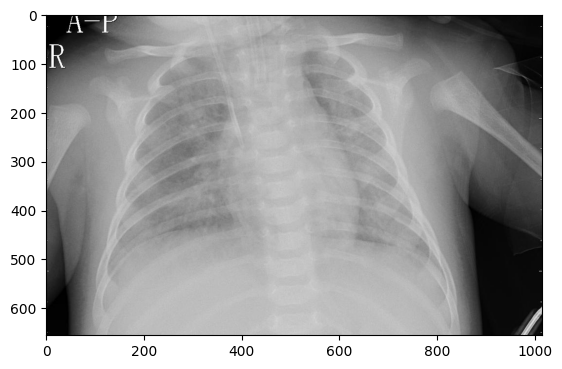

In [8]:
plt.imshow(img)
plt.show()

세균성 폐렴 환자의 폐 X선 영상

### 2) 활용할 수 있는 이미지를 모두 읽어서 변수에 저장하기

아래 프롬프트로 코드 생성하기 
* dataset_dir의 각 label 폴더에서 jpeg 파일 100개를 cv2로 읽는 get_data 함수 생성 해줘. 

In [9]:
def get_data(dataset_dir):
    images = []
    diagnoses = []
    for label in labels:
        label_dir = os.path.join(dataset_dir, label)
        jpeg_files = [f for f in os.listdir(label_dir) if f.lower().endswith('.jpeg')]
        selected_files = random.sample(jpeg_files, min(10, len(jpeg_files)))
        for fname in selected_files:
            img_path = os.path.join(label_dir, fname)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                diagnoses.append(label)
    return images, diagnoses

In [10]:
img_train, diagnoses_train = get_data(os.path.join(DATA_DIR, 'train'))
img_val, diagnoses_val = get_data(os.path.join(DATA_DIR, 'val'))
img_test, diagnoses_test = get_data(os.path.join(DATA_DIR, 'test'))

len(img_train), len(diagnoses_train), len(img_val), len(diagnoses_val), len(img_test), len(diagnoses_test)

(20, 20, 16, 16, 20, 20)

img_{dataset}에는 폐영상을, diagnosis_{dataset}에는 폐렴/정상에 대한 정보를 리스트 형태로 저장함. 학습/검증/평가 데이터 세트에는 폐렴/정상 데이터가 몇 개씩 있을지 확인해보자.

In [11]:
np.unique(diagnoses_train, return_counts=True),\
np.unique(diagnoses_val, return_counts=True),\
np.unique(diagnoses_test, return_counts=True)

((array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([10, 10])),
 (array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([8, 8])),
 (array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([10, 10])))

데이터 세트에 따른 폐렴과 정상 환자의 이미지 개수는?

 * 학습 데이터 세트(20): 정상-10, 폐렴-10 (원래, 정상-1341, 폐렴-3875)
 * 검증 데이터 세트(16): 정상-8, 폐렴-8
 * 테스트 데이터 세트(20): 정상-10, 폐렴-10

### 3) 데이터 시각화

`plt.imshow()`라는 메서드를 활용하여, 이미지 데이터를 숫자 -> 색으로 변환하여 시각적으로 확인할 수 있다.

(1499, 1966, 3)


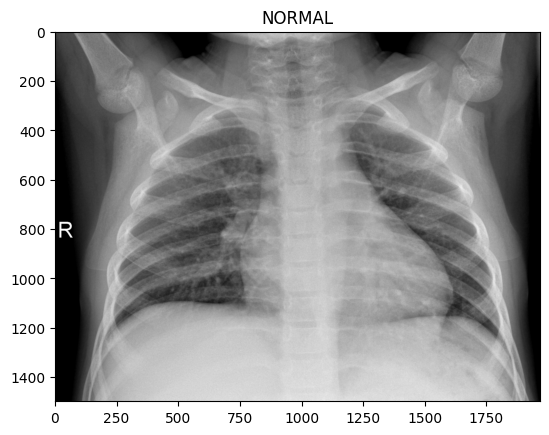

In [12]:
print(img_train[0].shape)
plt.imshow(img_train[0])
plt.title(diagnoses_train[0])
plt.show()

데이터 세트의 데이터를 하나씩 꺼내와서 시각화하고, 어떤 환자인지, 이미지의 크기는 어떤지 같이 확인하기 위한 아래 프롬프트를 이용하여 코드 생성하기 
* train, val, test 데이터의 첫번째와 마지막 이미지를 3x2 격자로 보여주고 diagnoses와 shape를 제목에 표시하는 그림 만들어줘

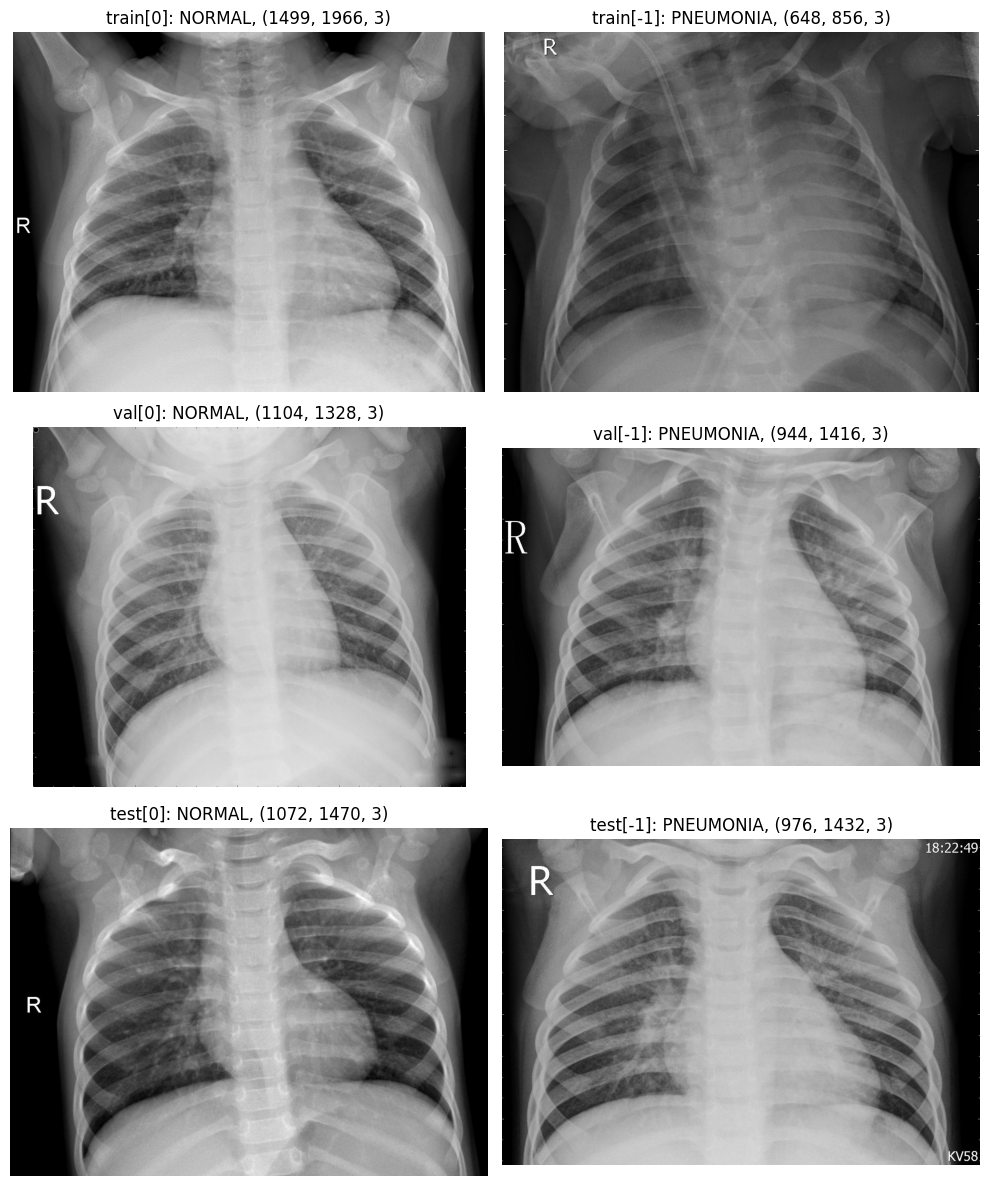

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Train: first and last
axes[0, 0].imshow(img_train[0])
axes[0, 0].set_title(f"train[0]: {diagnoses_train[0]}, {img_train[0].shape}")
axes[0, 1].imshow(img_train[-1])
axes[0, 1].set_title(f"train[-1]: {diagnoses_train[-1]}, {img_train[-1].shape}")

# Val: first and last
axes[1, 0].imshow(img_val[0])
axes[1, 0].set_title(f"val[0]: {diagnoses_val[0]}, {img_val[0].shape}")
axes[1, 1].imshow(img_val[-1])
axes[1, 1].set_title(f"val[-1]: {diagnoses_val[-1]}, {img_val[-1].shape}")

# Test: first and last
axes[2, 0].imshow(img_test[0])
axes[2, 0].set_title(f"test[0]: {diagnoses_test[0]}, {img_test[0].shape}")
axes[2, 1].imshow(img_test[-1])
axes[2, 1].set_title(f"test[-1]: {diagnoses_test[-1]}, {img_test[-1].shape}")

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

첫째 줄이 학습 데이터 세트, 둘째 줄이 검증 데이터 세트, 셋째 줄이 평가 데이터 세트인데, 데이터마다 크기와 비율이 제각각임을 알 수 있음

## 2. 데이터 전처리

### 1) 데이터 크기 조정

위 shape과 시각화 결과를 통해 데이터마다 크기가 다름을 확인함. 인공지능의 입력 데이터는 같은 크기를 가져야 함. 따라서 단일한 크기로 조정함. 영상의 크기는 다양하게 조절 가능한데, 오늘은 원활한 학습을 위해 작은 크기로 줄임

In [14]:
IMG_SHAPE = (224, 224, 3)

데이터 크기 조정해보기

(1499, 1966, 3)


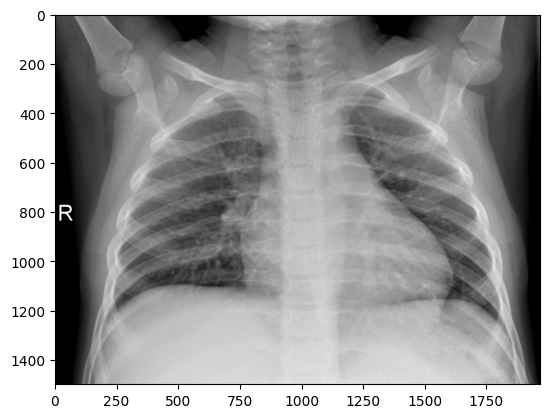

In [15]:
print(img_train[0].shape)
plt.imshow(img_train[0])
plt.show()

(224, 224, 3)


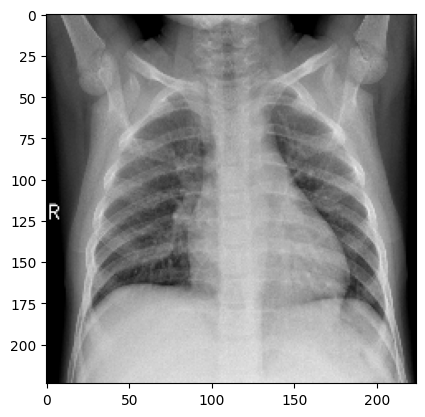

In [16]:
resized_img = cv2.resize(img_train[0], dsize=IMG_SHAPE[:2])
print(resized_img.shape)
plt.imshow(resized_img)
plt.show()

* (참고) `cv2.resize(img, dsize)` 메서드를 사용하여 이미지의 크기를 원하는 크기로 조정할 수 있음. 
* `interpolation=`은 영상의 크기를 조절하는 방식을 지정하는 파라미터로, 이미지의 크기를 줄일 때에는 주로 영역보간법(`INTER_AREA`)을 활용함

* 아래 프롬프트를 이용하여 이미지 resize를 진행해보자. 
  * img_train, img_val, img_test의 모든 이미지를 resize 해주고 이미지 크기는 IMG_SHAPE에 선언해두었음. tqdm을 활용한 진행바 표시도 부탁해.


In [17]:
def resize_images(img_list, target_shape):
    resized = []
    for img in tqdm(img_list, desc="Resizing images"):
        resized_img = cv2.resize(img, dsize=target_shape[:2], interpolation=cv2.INTER_AREA)
        resized.append(resized_img)
    return np.array(resized)

img_train = resize_images(img_train, IMG_SHAPE)
img_val = resize_images(img_val, IMG_SHAPE)
img_test = resize_images(img_test, IMG_SHAPE)

Resizing images: 100%|██████████| 20/20 [00:00<00:00, 118.07it/s]


In [18]:
diagnoses_train = np.array(diagnoses_train)
diagnoses_val = np.array(diagnoses_val)
diagnoses_test = np.array(diagnoses_test)

diagnoses_train.shape, diagnoses_val.shape, diagnoses_test.shape

((20,), (16,), (20,))

### 2) 데이터 셔플

현재 모든 데이터 세트의 데이터는 클래스 순서대로 구성됨. 이러한 데이터로 학습 시 모델에 편향이 발생할 수 있음. 데이터를 무작위로 섞는 셔플을 적용하여, 데이터에 있는 순서를 제거하자.

In [19]:
diagnoses_train 

array(['NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL',
       'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA'], dtype='<U9')

* 아래 프롬프트를 이용하여 데이터를 무작위로 섞는 셔플 기능 생성하기 
   * 데이터가 순서대로 정렬되어 있어서 학습 정확도에 좋지 않을 영향을 줄 거 같아. shuffle_data 함수 만들어줘. imgs, diagnoses를 같이 섞어서 반환되게 해야해. 

In [20]:
def shuffle_data(imgs, diagnoses):
    idx = np.random.permutation(len(imgs))
    return imgs[idx], diagnoses[idx]

In [21]:
img_train, diagnoses_train = shuffle_data(img_train, diagnoses_train)
img_val, diagnoses_val = shuffle_data(img_val, diagnoses_val)
img_test, diagnoses_test = shuffle_data(img_test, diagnoses_test)

In [22]:
diagnoses_train

array(['NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL',
       'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL',
       'PNEUMONIA', 'PNEUMONIA', 'NORMAL'], dtype='<U9')

### 3) 전처리가 끝난 데이터는?

In [23]:
img_train.shape, diagnoses_train.shape

((20, 224, 224, 3), (20,))

In [24]:
img_val.shape, diagnoses_val.shape

((16, 224, 224, 3), (16,))

In [25]:
img_test.shape, diagnoses_test.shape

((20, 224, 224, 3), (20,))

# III. CNN 모델 학습 및 평가 (DenseNet121)

## 5. 모델 빌드 및 컴파일

학습할 모델을 쌓고(빌드), 쌓은 모델의 학습에 사용할 loss function, optimizer를 지정하여 컴파일한다.

### 1) DenseNet121 아키텍처 파인 튜닝 (fine tuning)

In [27]:
model = build_pretrained_densenet121_model(IMG_SHAPE)
model.summary()

2025-08-29 06:27:20.140802: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

### 2) 모델 컴파일

In [28]:
EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 0.01

## 6. 모델 학습

### 1) 입출력 데이터 선언

In [30]:
model.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

CNN 모델의 입력은 3D 이미지임

In [31]:
X_train, X_val, X_test = img_train, img_val, img_test

X_train.shape, X_val.shape, X_test.shape

((20, 224, 224, 3), (16, 224, 224, 3), (20, 224, 224, 3))

In [32]:
y_train = np.squeeze(np.where(diagnoses_train == labels[0], 0, 1))
y_val = np.squeeze(np.where(diagnoses_val == labels[0], 0, 1))
y_test = np.squeeze(np.where(diagnoses_test == labels[0], 0, 1))

y_train.shape, y_val.shape, y_test.shape, y_train[0]

((20,), (16,), (20,), np.int64(0))

### 2) 모델 학습

하이퍼 파라미터 설정

`model.fit()`을 통해 모델 학습을 수행할 수 있음

In [33]:
# model training

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
)

Epoch 1/5


2025-08-29 06:28:40.048161: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25690112 exceeds 10% of free system memory.
2025-08-29 06:28:40.158726: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25690112 exceeds 10% of free system memory.
2025-08-29 06:28:40.182037: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25690112 exceeds 10% of free system memory.
2025-08-29 06:28:40.196501: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26615808 exceeds 10% of free system memory.
2025-08-29 06:28:40.497320: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 19267584 exceeds 10% of free system memory.


3/3 ━━━━━━━━━━━━━━━━━━━━ 75s 7s/step - accuracy: 0.5000 - loss: 1.3505 - val_accuracy: 0.5000 - val_loss: 331221663744.0000
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.3500 - loss: 1.9140 - val_accuracy: 0.5000 - val_loss: 21663906300489105408.0000
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.7000 - loss: 0.5902 - val_accuracy: 0.5000 - val_loss: 450900816904799125504.0000
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.4000 - loss: 0.9649 - val_accuracy: 0.5000 - val_loss: 12862726937491013632.0000
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7500 - loss: 0.4477 - val_accuracy: 0.5000 - val_loss: 2545577225999089664.0000


### 3) Learning curve 확인하기

학습이 잘 수행되었다면, 실제 데이터와 예측 결과 데이터의 손실이 학습이 진행됨에 따라 줄어들어야 함.

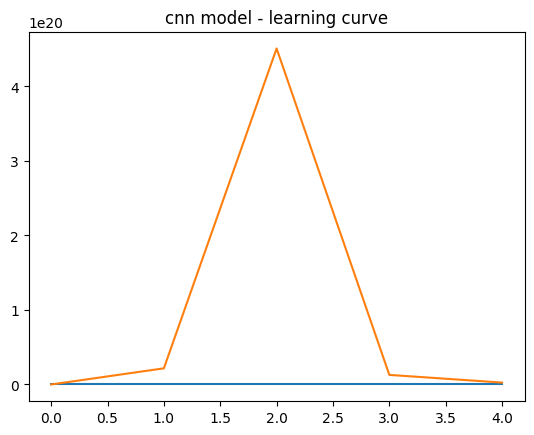

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('cnn model - learning curve')
plt.show()

## 7. 모델 평가하기

모델이 잘 만들어졌는지 평가 데이터로 확인

### 1) 정확도 계산하기

학습이 잘 수행되었는지 확인하기 위해서는 평가 데이터를 통해 정확도를 계산해야 함. 정확도는 다음과 같음.

> Accuracy(%) = (제대로 예측된 데이터의 개수) / (전체 데이터 개수) * 100

In [35]:
model.evaluate(X_test, y_test, verbose=1)
model.evaluate(X_val, y_val, verbose=1)
model.evaluate(X_train, y_train, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5000 - loss: 2314646249061482496.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 2545577225999089664.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 2435574386174984192.0000


[2.435574386174984e+18, 0.5]